# Distributed mesh simulations

<div class="admonition note">
**Topics**: Distributed mesh solver, Local mesh elements, distributed data saving.
</div>

Althouth the `'TetOpSplit'` solver runs simulations in parallel, the mesh is still fully loaded in each of the MPI processes. This can become a limiting factor when larger meshes are used. Since STEPS 4.0, a new solver, `'DistTetOpSplit'` was added to tackle this issue. This solver loads the mesh in a distributed way, meaning that each MPI process only loads the part of the mesh that it will simulate.

For more details about the performace of the `'DistTetOpSplit'` distributed mesh solver, please check the following paper:

Weiliang Chen, Tristan Carel, Omar Awile, Nicola Cantarutti, Giacomo Castiglioni, Alessandro Cattabiani, Baudouin Del Marmol, Iain Hepburn, James G King, Christos Kotsalos, Pramod Kumbhar, Jules Lallouette, Samuel Melchior, Felix Schürmann, Erik De Schutter (2022). **STEPS 4.0: Fast and memory-efficient molecular simulations of neurons at the nanoscale**. Front. Neuroinform. Volume 16. https://doi.org/10.3389/fninf.2022.883742.


## Converting parallel simulations to distributed

Changing from the `'TetOpSplit'` parallel solver to the `'DistTetOpSplit'` distributed solver requires a few extra changes to STEPS python scripts.
To show these changes, we will use a slightly modified version of the stochastic calcium burst model introduced previously. We will not go through the entire script but we will focus instead on the parts that are relevant to distributed simulations.

The script that we will use in this chapter can be downloaded [here](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_Distributed.py):
```python
import steps.interface

from steps.geom import *
from steps.model import *
from steps.rng import *
from steps.saving import *
from steps.sim import *
from steps.utils import *

import numpy as np

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

###########################################################
# Simulation Parameters
###########################################################

ENDT = 0.06

DT =  2.0e-5

EF_DT = 5.0e-6

SEED = 1234

###########################################################
# Model Parameters
###########################################################

TEMPERATURE = 34.0 + 273.15
Q10 = 3

FARADAY = 96485.3365     # C/mol
R = 8.3144621            # J/mol K
AVOGADRO = 6.02214129e23 # /mol

Qt = Q10 ** ((TEMPERATURE - (23 + 273.15)) / 10)
Qt_mslo = Q10 ** ((TEMPERATURE - (25 + 273.15))/10)

#######################################
# Membrane Parameters
#######################################

init_pot = Parameter(-60, 'mV', Description='Initial membrane potential')
Ra = Parameter(235.7*1.0e-2, 'ohm m', Description='Bulk resistivity')
Cm = 0.64e-2
memb_capac_proximal = Parameter(1.2*Cm, 'F m^-2', Description='Smooth membrane capacitance')
memb_capac_spiny = Parameter(5.3*Cm, 'F m^-2', Description='Spiny membrane capacitance')

#######################################
# CaP channels parameters
#######################################

CaP_P = Parameter(2.5e-2, 'um^3 s^-1', Description='CaP single channel permeability')
CaP_ro = Parameter(38, 'um^-2', Description='CaP channels density')

# Reaction rates

vhalfm = -29.458 # mV
cvm = 8.429      # mV

def minf_cap(mV):
    vhalfm = -29.458
    cvm = 8.429
    return 1 / (1 + np.exp(-(mV - vhalfm) / cvm))

def tau_cap(mV):
    if mV >= -40:
        return 0.2702 + 1.1622 * np.exp(-(mV + 26.798) ** 2 / 164.19)
    else:
        return 0.6923 * np.exp(mV / 1089.372)

alpha_cap = VDepRate.Create(
    lambda V: (minf_cap(V * 1e3) / tau_cap(V * 1e3)) * Qt * 1e3
)
beta_cap = VDepRate.Create(
    lambda V: (1 - minf_cap(V * 1e3)) / tau_cap(V * 1e3) * Qt * 1e3
)

# Initial conditions
CaP_p = [0.92402, 0.073988, 0.0019748, 1.7569e-05]

#######################################
# CaT channels parameters
#######################################

CaT_P = Parameter(1.65e-2, 'um^3 s^-1', Description='CaT single channel permeability')
CaT_ro = Parameter(1.9636, 'um^-2', Description='CaT channels density')

# Reaction rates

def minf_cat(mV):
    vhalfm = -52
    cvm = -5
    return 1 / (1 + np.exp((mV - vhalfm) / cvm))

def taum_cat(mV):
    if mV > -90:
        return 1 + 1 / (np.exp((mV + 40) / 9) + np.exp(-(mV + 102) / 18))
    else:
        return 1

def hinf_cat(mV):
    vhalfh = -72
    cvh = 7
    return 1 / (1 + np.exp((mV - vhalfh) / cvh))

def tauh_cat(mV):
    return (15 + 1 / (np.exp((mV + 32) / 7)))

alpham_cat = VDepRate.Create(lambda V: minf_cat(V * 1e3) / taum_cat(V * 1e3) * 1e3)
betam_cat = VDepRate.Create(lambda V: (1 - minf_cat(V * 1e3)) / taum_cat(V * 1e3) * 1e3)

alphah_cat = VDepRate.Create(lambda V: hinf_cat(V * 1e3) / tauh_cat(V * 1e3) * 1e3)
betah_cat = VDepRate.Create(lambda V: (1 - hinf_cat(V * 1e3)) / tauh_cat(V * 1e3) * 1e3)

# Initial conditions
CaT_p = [
    [0.58661, 0.23687, 0.023912],   # h0
    [0.10564, 0.042658, 0.0043063], # h1
]

#######################################
# BK channels parameters
#######################################

BK_G = Parameter(210, 'pS', Description='BK single channel conductance')
BK_ro = Parameter(1.5 * 2.0238, 'um^-2', Description='BK channels density')
BK_rev = Parameter(-77, 'mV', Description='BK channel reversal potential')

# Reaction rates

#Units (1)
Qo = 0.73
Qc = -0.67

#Units (/s)
pf0 = 2.39
pf1 = 5.4918
pf2 = 24.6205
pf3 = 142.4546
pf4 = 211.0220

pb0 = 3936
pb1 = 687.3251
pb2 = 234.5875
pb3 = 103.2204
pb4 = 11.6581

#Units(/M)
k1 = 1.0e6

#Units(/s)
onoffrate = 1.0e3

L0 = 1806

#Units (M)
Kc = 8.63e-6
Ko = 0.6563e-6

BK_f = k1*onoffrate*Qt_mslo
BKo_b = Ko*k1*onoffrate*Qt_mslo
BKc_b = Kc*k1*onoffrate*Qt_mslo

BK_f0 = VDepRate.Create(
    lambda V: pf0 * Qt_mslo * (np.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f1 = VDepRate.Create(
    lambda V: pf1 * Qt_mslo * (np.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f2 = VDepRate.Create(
    lambda V: pf2 * Qt_mslo * (np.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f3 = VDepRate.Create(
    lambda V: pf3 * Qt_mslo * (np.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_f4 = VDepRate.Create(
    lambda V: pf4 * Qt_mslo * (np.exp((Qo * FARADAY * V) / (R * TEMPERATURE)))
)
BK_oc_f = [BK_f0, BK_f1, BK_f2, BK_f3, BK_f4]

BK_b0 = VDepRate.Create(
    lambda V: pb0 * Qt_mslo * (np.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b1 = VDepRate.Create(
    lambda V: pb1 * Qt_mslo * (np.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b2 = VDepRate.Create(
    lambda V: pb2 * Qt_mslo * (np.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b3 = VDepRate.Create(
    lambda V: pb3 * Qt_mslo * (np.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_b4 = VDepRate.Create(
    lambda V: pb4 * Qt_mslo * (np.exp((Qc * FARADAY * V) / (R * TEMPERATURE)))
)
BK_oc_b = [BK_b0, BK_b1, BK_b2, BK_b3, BK_b4]

# Initial conditions
BK_p = [
    [0.99997,    4.3619e-07, 4.1713e-09, 4.4449e-11, 6.3132e-14],
    [2.5202e-05, 1.1765e-06, 6.6148e-08, 2.4392e-09, 4.0981e-11],
]

#######################################
# SK channels parameters
#######################################

SK_G = Parameter(10, 'pS', Description='SK single channel conductance')
SK_ro = Parameter(0.31, 'um^-2', Description='SK channels density')
SK_rev = Parameter(-77, 'mV', Description='SK channel reversal potential')

# Reaction rates

#Units (/s)
invc1 = 80
invc2 = 80
invc3 = 200

invo1 = 1000
invo2 = 100

diro1 = 160
diro2 = 1200

#Units ( /s M)

dirc2 = 200e6
dirc3 = 160e6
dirc4 = 80e6

invc1_t = invc1*Qt
invc2_t = invc2*Qt
invc3_t = invc3*Qt

invo1_t = invo1*Qt
invo2_t = invo2*Qt

diro1_t = diro1*Qt
diro2_t = diro2*Qt

dirc2_t = dirc2*Qt/3.0
dirc3_t = dirc3*Qt/3.0
dirc4_t = dirc4*Qt/3.0

# Intital conditions
SK_C1_p= 0.96256
SK_C2_p= 0.036096
SK_C3_p= 0.0010829
SK_C4_p= 6.4973e-06

SK_O1_p= 0.00017326
SK_O2_p= 7.7967e-05

#######################################
# AMPA channels parameters
#######################################

AMPA_G = Parameter(7, 'pS', Description="AMPA channel conductance")
AMPA_Ro = Parameter(20, 'um^-2', Description="AMPA channek density")
AMPA_rev = Parameter(0, 'mV', Description="AMPA channel reversal potential")

#Units (/s M)

rb = 13e6

#Units (/s)

ru1 = 0.0059e3
ru2 = 86e3
ro = 2.7e3
rc = 0.2e3
rd = 0.9e3
rr = 0.064e3

# Glutamate transient

# Units (s)

glut_start = 5e-3

# Units (M), Reference (Rudolph et al. 2011)
def Glut(t):
    if t >= 0:
        return 12e-3 * (0.86 * np.exp(-t / 0.4e-3) + 0.14 * np.exp(-t / 4.2e-3))
    else:
        return 0

#######################################
# Leak channels parameters
#######################################

L_G = Parameter(0.4, 'pS', Description='Leak single channel conductance')
L_ro_proximal = Parameter(0.25, 'um^-2', Description='Proximal leak channels density')
L_ro_spiny = Parameter(1, 'um^-2', Description='Proximal leak channels density')
L_rev = Parameter(-61, 'mV', Description='Leak channel reversal potential')

#######################################
# Ca pump channels parameters
#######################################

P_ro = Parameter(6.022141, 'um^-2', Description='Ca2+ pump density')

# Reaction rates

P_f = 3e9
P_b = 1.75e4
P_k = 7.255e4

#######################################
# Calcium buffering parameters
#######################################

# Ca concentrations

Ca_oconc = 2e-3
Ca_iconc = 45e-9

# Mg concentrations

Mg_conc = 590e-6

# Buffer concentrations

iCBsf_conc = 27.704e-6
iCBCaf_conc = 2.6372e-6
iCBsCa_conc= 1.5148e-6
iCBCaCa_conc= 0.14420e-6

CBsf_conc= 110.82e-6
CBCaf_conc= 10.549e-6
CBsCa_conc= 6.0595e-6
CBCaCa_conc= 0.57682e-6

PV_conc= 3.2066e-6
PVCa_conc= 16.252e-6
PVMg_conc= 60.541e-6

# Diffusion constants

DCST = 0.223e-9 # Ca
DCB = 0.028e-9  # Calbindin (CB)
DPV = 0.043e-9  # Parvalbumin (PV)

# Reaction rates

CBf_f_kcst = 4.35e7
CBf_b_kcst = 35.8

CBs_f_kcst = 0.55e7
CBs_b_kcst = 2.6

PVca_f = 10.7e7
PVca_b = 0.95

PVmg_f_kcst = 0.8e6
PVmg_b_kcst = 25

###########################################################
# Mesh Parameters
###########################################################

mesh_file = '../meshes/caburst_dist/split_256/CNG_segmented_2_split_256'

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

###########################################################
# Biochemical model
###########################################################

mdl = Model()
with mdl:
    # Species
    Pump, CaPump, PV, PVMg, PVCa, Mg = Species.Create()
    Ca = Species.Create(valence=2)

    # Calbindin
    CBs, CBf, CBsCa, CBfCa, CBmob, CBimmob = SubUnitState.Create()
    CBsSU, CBfSU, CBmobSU = SubUnit.Create(
        [CBs, CBsCa], [CBf, CBfCa], [CBmob, CBimmob]
    )
    CB = Complex.Create([CBsSU, CBfSU, CBmobSU])

    # Channels
    CaPc, CaPo = SubUnitState.Create()
    CaP_SU = SubUnit.Create([CaPc, CaPo])
    CaPchan = Channel.Create([CaP_SU, CaP_SU, CaP_SU])

    BK, BKCa, BKopen, BKclose = SubUnitState.Create()
    BKCaSU = SubUnit.Create([BK, BKCa])
    BKocSU = SubUnit.Create([BKopen, BKclose])
    BKchan = Channel.Create([BKCaSU, BKCaSU, BKCaSU, BKCaSU, BKocSU])

    SK_C1, SK_C2, SK_C3, SK_C4, SK_O1, SK_O2 = SubUnitState.Create()
    SKchan = Channel.Create([SK_C1, SK_C2, SK_C3, SK_C4, SK_O1, SK_O2])

    AMPA_C, AMPA_C1, AMPA_C2, AMPA_D1, AMPA_D2, AMPA_O = SubUnitState.Create()
    AMPA = Channel.Create([AMPA_C, AMPA_C1, AMPA_C2, AMPA_D1, AMPA_D2, AMPA_O])

    Leak = SubUnitState.Create()
    L = Channel.Create([Leak])
    
    r = ReactionManager()

    vsys = VolumeSystem.Create()
    with vsys:
        # PVCa
        PV + Ca <r[1]> PVCa
        r[1].K = PVca_f, PVca_b

        # PVMg
        PV + Mg <r[1]> PVMg
        r[1].K = PVmg_f_kcst, PVmg_b_kcst

        with CB[...]:
            # Fast binding
            CBf + Ca <r[1]> CBfCa
            r[1].K = CBf_f_kcst, CBf_b_kcst

            # Slow binding
            CBs + Ca <r[1]> CBsCa
            r[1].K = CBs_f_kcst, CBs_b_kcst

        diff_Ca   = Diffusion.Create(Ca, DCST)
        diff_CB   = Diffusion.Create(CB[:, :, CBmob], DCB)
        diff_PV   = Diffusion.Create(PV, DPV)
        diff_PVCa = Diffusion.Create(PVCa, DPV)
        diff_PVMg = Diffusion.Create(PVMg, DPV)

    ssys = SurfaceSystem.Create()
    with ssys:
        # Ca Pump
        Pump.s + Ca.i <r[1]> CaPump.s >r[2]> Pump.s
        r[1].K = P_f, P_b
        r[2].K = P_k
    
        # CaP channel
        with CaPchan[...]:
            CaPc.s <r[1]> CaPo.s
            r[1].K = VDepRate(alpha_cap), VDepRate(beta_cap)
        OC_CaP = GHKCurr.Create(
            CaPchan[CaPo, CaPo, CaPo], Ca, CaP_P,
            computeflux=True, virtual_oconc=Ca_oconc
        )
    
        # BK channel
        with BKchan[..., BKclose]:
            BK.s + Ca.i <r[1]> BKCa.s
            r[1].K = BK_f, BKc_b

        with BKchan[..., BKopen]:
            BK.s + Ca.i <r[1]> BKCa.s
            r[1].K = BK_f, BKo_b

        with BKchan[...]:
            BKclose.s <r[1]> BKopen.s
            r[1].K = (
                CompDepRate(lambda s: BK_oc_f[s.Count(BKCa)], [BKchan]),
                CompDepRate(lambda s: BK_oc_b[s.Count(BKCa)], [BKchan])
            )
        OC_BK = OhmicCurr.Create(BKchan[..., BKopen], BK_G, BK_rev)

        # SK channel
        with SKchan[...]:
            ((SK_C1.s + Ca.i <r[1]> SK_C2.s)\
                      + Ca.i <r[2]> SK_C3.s)\
                      + Ca.i <r[3]> SK_C4.s
            r[1].K = dirc2_t, invc1_t
            r[2].K = dirc3_t, invc2_t
            r[3].K = dirc4_t, invc3_t
            
            SK_C3.s <r[1]> SK_O1.s
            SK_C4.s <r[2]> SK_O2.s
            r[1].K = diro1_t, invo1_t
            r[2].K = diro2_t, invo2_t
        OC_SK = OhmicCurr.Create(SKchan[SK_O1|SK_O2], SK_G, SK_rev)

        # AMPA channel
        with AMPA[...]:
            AMPA_C.s <r['A1']> AMPA_C1.s <r['A2']> AMPA_C2.s <r[3]> AMPA_O.s
            r['A1'].K = 0, ru1
            r['A2'].K = 0, ru2
            r[3].K = ro, rc

            AMPA_C1.s <r[1]> AMPA_D1.s
            AMPA_C2.s <r[2]> AMPA_D2.s
            r[1].K = rd, rr
            r[2].K = rd, rr
        OC_AMPAR1 = OhmicCurr.Create(AMPA[AMPA_O], AMPA_G, AMPA_rev)

        # Leak current channel
        OC_L = OhmicCurr.Create(L[Leak], L_G, L_rev)
    
###########################################################
# Mesh and compartmentalization
###########################################################

mesh = DistMesh(mesh_file, 1e-6)

with mesh.asLocal(owned=False):
    cyto = Compartment.Create(mesh.tets, vsys)
    cyto.Conductivity = 1 / Ra

    smoothTets = mesh.tetGroups['smooth']
    spinyTets = mesh.tetGroups['spiny']

    smooth = Patch.Create(smoothTets.surface & mesh.surface, cyto, None, ssys)
    spiny = Patch.Create(spinyTets.surface & mesh.surface, cyto, None, ssys)

    memb_smooth = Membrane.Create([smooth], capacitance=memb_capac_proximal)
    memb_spiny = Membrane.Create([spiny], capacitance=memb_capac_spiny)

###########################################################
# Simulation
###########################################################

rng = RNG('mt19937', 512, SEED)

sim = Simulation(
    'DistTetOpSplit', mdl, mesh, rng,
    searchMethod=NextEventSearchMethod.GIBSON_BRUCK
)

rs = ResultSelector(sim)

with mesh.asLocal():
    Pots = rs.VERTS(mesh.surface.verts).V
    CaConc = rs.TETS().Ca.Conc
    CaConc.metaData['Vols'] = [tet.Vol for tet in mesh.tets]
    Currents = rs.TRIS(mesh.surface).OC_CaP.I

sim.toSave(Pots, CaConc, Currents, dt=DT)

with XDMFHandler('DistCaburst') as hdf:
    sim.toDB(hdf, 'CaBurstSim')

    sim.newRun()

    # Set temperature for ghk reactions
    sim.Temp = TEMPERATURE + 273.15

    # Setting initial conditions
    simPatches = [sim.smooth, sim.spiny]
    smoothArea = Parameter(smooth.Area, 'm^2')
    spinyArea = Parameter(spiny.Area, 'm^2')
    for patch, area in zip(simPatches, [smoothArea, spinyArea]):
        patch.Pump.Count = round(P_ro * area)

        for s in CaPchan[...]:
            patch.LIST(s).Count = round(CaP_ro*area*CaP_p[s.Count(CaPo)])

        for s in BKchan[...]:
            isOpen, nbCa = s.Count(BKopen), s.Count(BKCa)
            patch.LIST(s).Count = round(BK_ro*area*BK_p[isOpen][nbCa])

        patch.SKchan[SK_C1].Count = round(SK_ro*area*SK_C1_p)
        patch.SKchan[SK_C2].Count = round(SK_ro*area*SK_C2_p)
        patch.SKchan[SK_C3].Count = round(SK_ro*area*SK_C3_p)
        patch.SKchan[SK_C4].Count = round(SK_ro*area*SK_C4_p)
        patch.SKchan[SK_O1].Count = round(SK_ro*area*SK_O1_p)
        patch.SKchan[SK_O2].Count = round(SK_ro*area*SK_O2_p)

    sim.spiny.L[Leak].Count = round(L_ro_spiny * spinyArea)
    sim.smooth.L[Leak].Count = round(L_ro_proximal * smoothArea)

    sim.smooth.AMPA[AMPA_C].Count = round(AMPA_Ro * smoothArea)

    sim.cyto.Ca.Conc = Ca_iconc
    sim.cyto.Mg.Conc = Mg_conc

    sim.cyto.CB[CBs,   CBf,   CBimmob].Conc = iCBsf_conc
    sim.cyto.CB[CBsCa, CBf,   CBimmob].Conc = iCBCaf_conc
    sim.cyto.CB[CBs,   CBfCa, CBimmob].Conc = iCBsCa_conc
    sim.cyto.CB[CBsCa, CBfCa, CBimmob].Conc = iCBCaCa_conc

    sim.cyto.CB[CBs,   CBf,   CBmob].Conc = CBsf_conc
    sim.cyto.CB[CBsCa, CBf,   CBmob].Conc = CBCaf_conc
    sim.cyto.CB[CBs,   CBfCa, CBmob].Conc = CBsCa_conc
    sim.cyto.CB[CBsCa, CBfCa, CBmob].Conc = CBCaCa_conc

    sim.cyto.PV.Conc = PV_conc
    sim.cyto.PVCa.Conc = PVCa_conc
    sim.cyto.PVMg.Conc = PVMg_conc

    sim.EfieldDT = EF_DT

    sim.ALL(Membrane).Potential = init_pot

    for t in np.arange(0, ENDT, DT):
        if MPI.rank == 0:
            print(f'Run timestep {t}')
        # Update AMPA receptors reaction rate
        sim.smooth.A1['fwd'].K = rb * Glut(t - glut_start)
        sim.smooth.A2['fwd'].K = rb * Glut(t - glut_start)

        sim.run(t)
```

The biochemical model declaration does not involve anything specific to the distributed mesh solver and is thus identical for parallel or even serial simulations. In this chapter, we will mainly focus on the differences related to geometry declaration.

## Mesh partionioning and loading

In this chapter, we will use the following reconstructed mesh of a Purkinje cell dendritic tree:

<img src="images/distributed_full_mesh.png"/>

The mesh can be downloaded [here](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/meshes/caburst_dist/CNG_segmented_2.msh) and visualized with [Gmsh](http://gmsh.info/).
Note that the mesh tetrahedrons are classified and annotated into two components, representing smooth dendrite (orange) and spiny dendrite (green). These annotations will then be used in STEPS for creating corresponding patches.

Distributed meshes are created in the python script with [Distmesh](API_geom.rst#steps.API_2.geom.DistMesh), a different class from the one that was used for parallel simulations (`TetMesh`). In contrast to `TetMesh`, that could load meshes from a variety of file formats, distributed meshes can only be created from meshes saved to the [Gmsh](http://gmsh.info/) format.
However, while `TetMeshes` required an additional partitioning step in the python script, `DistMesh` can automatically be partitioned upon mesh creation:

```python
mesh = DistMesh('path/to/mesh_file.msh, scale=1e-6)
```

The above line loads and distributes the mesh. Like for `TetMesh`, it also takes a `scale` parameter to rescale the dimensions to meters, if needed.

Although the automatic partitioning is convenient, it can often lead to sub-optimal partitions in which spatially close but disconnected parts of the mesh are grouped in the same partition. In addition, the mesh has to be fully loaded by one MPI rank before being distributed, which can be an issue in cases where the mesh is too big to fully fit in memory. As we saw in the [parallel simulations](STEPS_Tutorial_MPI.ipynb) chapter, it is usually better to pre-partition meshes with dedicated partitioning software like [Metis](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview).

In this chapter, we will thus pre-partition the mesh from the [Gmsh](http://gmsh.info/) software but save each partition to a separate file, so that, when loaded into STEPS, each MPI rank will only load its part of the mesh in memory.

Once the mesh is loaded in Gmsh, it can be partitioned with Modules $\rightarrow$ Mesh $\rightarrow$ Partition, which opens the following dialog:

<img src="images/distributed_metis_partitioning.png"/>

We will split it into 256 partitions using Metis. After the partitioning is complete, we can see the partitions that METIS created:

<img src="images/distributed_partitioned_mesh.png"/>

Each color represents a different partition. We then export the mesh with File $\rightarrow$ Export..., select a destination folder and a file name ending with the .msh extension. We then make sure that "Save one file per partition" is checked in the following dialog:

<img src="images/distributed_export_split.png"/>

This splits the mesh into 256 distinct files suffixed with `_1.msh`, `_2.msh`, etc. The corresponding files can be downloaded from [here](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/meshes/caburst_dist/split_256/)

In STEPS, the mesh is then loaded with e.g.:
```python
mesh = Distmesh('path/to/mesh_prefix', scale=1e-6)
```
We only give the part of the path that is common to all split mesh files (excluding the underscore before the partition number) and STEPS will automatically load `path/to/mesh_prefix_1.msh` in rank 0, `path/to/mesh_prefix_2.msh` in rank 1, etc. This is the method that we use in the script that we take as example in this chapter:

```python
###########################################################
# Mesh Parameters
###########################################################

mesh_file = '../meshes/caburst_dist/split_256/CNG_segmented_2_split_256'

#...

###########################################################
# Mesh and compartmentalization
###########################################################

mesh = DistMesh(mesh_file, 1e-6)

#...
```

## Local and global element lists

Each MPI rank loads the part of the mesh that corresponds to its partition. The elements (tetrahedrons, triangles, vertices) can then be refered to by two types of indices: a **global** index that uniquely identifies the element accross all MPI ranks; and a **local** index that is specific to each MPI rank. The following schematic shows a mesh split in two partitions along with the global (top part) and local (bottom part) indices of elements. For simplicity, we represent triangles intead of tetrahedrons but the same ideas apply to tetrahedral meshes.

<img src="images/distributed_partition_schematic.png"/>

The green tetrahedrons are owned by rank 0 and the blue tetrahedrons by rank 1. The thicker red line represents the boundary between the two partitions. Note that in addition to the elements that are owned by an MPI rank (represented in darker colors and solid borders), each MPI rank also contains a shell of non-owned (or "ghost") elements (represented in lighter colors and dashed borders) at the partition boundary. These non-owned elements share vertices with owned elements but are owned by a different MPI rank. These non-owned elements are required for synchronizing diffusion events across partition boundaries.

As can be seen on the schematic, the global and local indices are in general different and it is thus important to keep track of whether a list of elements contains indices that are global or local to the MPI rank. By default, to ensure compatibility with code written for non-distributed `TetMesh` meshes, all element lists are created as global lists. We can thus create the `GlobalLst` list that is represented on the top part of the schematic (solid yellow borders) with:
```python
with mesh:
    GlobalLst = TetList([45, 40, 46, 52, 38, 37])
```
The indices that we give are the global element indices, and both rank 0 and rank 1 hold the same list that refers to the same elements.

To specify that a list is created from local indices, all lists of elements can be given an additional `local` keyword parameter. So we can declare the `LocalLst` list that is represented on the bottom part of the schematic (solid pink borders) with:
```python
with mesh:
    LocalLst = TetList([0, 1, 2, 3], local=True)
```
Note that although both ranks execute the same code and display the same value of `LocalLst.indices`, the list refers to different mesh elements in rank 0 and rank 1. 

### Local / global conversions

We can convert the local list to its global counterpart with `localLst.toGlobal()`:

| Variable | Rank 0  | Rank 1 |
|---|---|---|
| `LocalLst.indices` | `[0, 1, 2, 3]` |`[0, 1, 2, 3]`|
| `LocalLst.toGlobal().indices` | `[4, 5, 9, 19]` |`[0, 1, 2, 3]`|

Although the local and global indices of some elements (like `localLst` in rank 1 here) can be identical, global and local indices are in general different.

Converting a local list to global is always guaranteed to return a list that has the same number of elements. However, the reverse conversion from global to local, done with e.g. `GlobalLst.toLocal()`, will discard the elements that are not owned by the MPI rank in which the conversion occurs. The corresponding local lists are shown in the bottom part of the schematic (solid orange border).

If the `toLocal` method is given an `owned=False` keyword parameter, the returned list will also include elements that are local to the MPI rank but which are not owned by it. These lists are represented with dashed brown borders on the schematic.

| Variable | Rank 0  | Rank 1 |
|---|---|---|
| `GlobalLst.indices` | `[45, 40, 46, 52, 38, 37]` |`[45, 40, 46, 52, 38, 37]`|
| `GlobalLst.toLocal().indices` | `[20, 16, 21]` |`[28, 23, 22]`|
| `GlobalLst.toLocal(owned=False).indices` | `[20, 16, 21, 63, 59]` |`[58, 60, 28, 23, 22]`|

Depending on whether we include non-owned elements (`owned=False`), the number of elements in local lists can be different. In general, we only need to consider non-owned elements when declaring compartments or patches from local lists of elements. In that case, non-owned elements are necessary so that each MPI rank can know whether diffusion can occur to the elements in other MPI ranks.

Since the `toLocal` method can change the number of elements in the list, when the elements are shared across several MPI ranks, we cannot recover the original global list by calling `toGlobal`. `GlobalLst.toLocal()` basically distributes its elements to the MPI ranks that owned them. We can however recover the original list with the [combineWithOperator](API_geom.rst#steps.API_2.geom.RefList.combineWithOperator) method:

```python
import operator

with mesh:
    lst = TetList([45, 40, 46, 52, 38, 37])
    lst_local = lst.toLocal()
    
    lst_local_global = lst_local.toGlobal()
    lst_merge = lst_local.combineWithOperator(operator.or_)
```
This code results in the following values:
    
| Variable | Rank 0  | Rank 1 |
|---|---|---|
| `lst.indices` | `[45, 40, 46, 52, 38, 37]` |`[45, 40, 46, 52, 38, 37]`|
| `lst_local.indices` | `[20, 16, 21]` |`[28, 23, 22]`|
| `lst_local_global.indices` | `[45, 40, 46]` |`[52, 38, 37]`|
| `lst_merge.indices` | `[45, 40, 46, 52, 38, 37]` |`[45, 40, 46, 52, 38, 37]`|

Calling the `combineWithOperator` method allows us to recover the original global list. This method takes a binary operator that should combine two lists into a merged list, this operator gets repeatedly applied to create the merged list.
Any function that takes two global lists and returns a global list can be given to `combineWithOperator` but most of the time, it is easier to use one of the binary operator functions in the [operator](https://docs.python.org/3/library/operator.html) python package. Here we use `operator.or_`, which corresponds to the `|` operator that we would normally use to combine lists (see the [corresponding chapter](STEPS_Tutorial_Diffusion.ipynb)).

In order to determine whether a given element list is local, one can call the [isLocal](API_geom.rst#steps.API_2.geom.RefList.isLocal) method.

### Using the mesh locally

Element lists that are directly accessed through the mesh or its components (compartments, patches, membranes, etc.) are global lists by default. To avoid the MPI synchronization necessary to obtain these global lists, it is possible to use the [asLocal](API_geom.rst#steps.API_2.geom.DistMesh.asLocal) method with the following syntax:

```python
with mesh.asLocal():
    localTets = mesh.tets
```

As long as we are in the `with mesh.asLocal():` block, mesh properties will be local by default. The same thing applies to mesh components like compartments, etc. Note that `with mesh.asLocal():` does not change whether lists created in the block will be global or local, the `local` keyword argument should still be provided to all lists that are explicitely created, and global lists can still be used in a `with mesh.asLocal():` block.

Like for `toLocal`, the `asLocal` method can take an `owned` keyword argument that defaults to `True` so the above code only considers owned elements. To consider non-owned elements as well, one would write:

```python
with mesh.asLocal(owned=False):
    allLocalTets = mesh.tets
```

This is usually not needed, except when declaring compartments or patches from lists of local elements. As we saw earlier, non-owned elements are necessary for diffusion and since diffusions operate within compartments / patches, each MPI rank needs to know whether its non-owned elements are part of the same compartment / patch as its owned elements.

Finally, when using distributed meshes, it is advisable to use `with mesh.asGlobal():` instead of `with mesh:`. They have the same effect since the mesh is in global mode by default, but the former makes it clearer which parts of the code use the mesh globally.

## Physical group tags

The gmsh file format allows the creation of [physical group](http://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups) tags in the mesh file. Physical groups have a unique integer identifier in the mesh but can also be given a name. The mesh that we use in this chapter has two physical groups: `spiny` and `smooth` corresponding respectively to tetrahedrons from the spiny dendrites and to tetrahedrons of the smooth dendrites (displayed in green and orange earlier).

In a STEPS script, we can get a list of elements that are tagged with e.g.:
```python
with mesh:
    smoothTets = mesh.tetGroups['smooth']
```
As we saw in the previous section, this would return a global list of all tetrahedrons that are tagged with the 'smooth' tag. If we want only the local tetrahedrons (including non-owned tetrahedrons) we would use:
```python
with mesh.asLocal(owned=False):
    localSmoothTets = mesh.tetGroups['smooth']
```

There are three `DistMesh` properties that allow access to tagged elements:

- [tetGroups](API_geom.rst#steps.API_2.geom.DistMesh.tetGroups) that gives access to tagged tetrahedrons
- [triGroups](API_geom.rst#steps.API_2.geom.DistMesh.triGroups) that gives access to tagged triangles
- [vertGroups](API_geom.rst#steps.API_2.geom.DistMesh.vertGroups) that gives access to tagged vertices

We will not use `triGroups` or `vertGroups` in this chapter but they work in the same way as `tetGroups`.

## Creating compartments and patches

### Compartments

Going back to our main example, we first create the `cyto` compartment. This compartment will contain all the tetrahedrons in the mesh and will thus be created from the `mesh.tets` list. We could declare it as we would in a `'TetOpSplit'` simulation, using global indices:
```python
with mesh:
    cyto = Compartment.Create(mesh.tets, vsys)
    # ...
```
The issue with this code, however, is that all MPI ranks will hold `mesh.tets`, the full list of tetrahedrons in the whole mesh. Since the goal of a distributed simulation is to have each MPI rank only consider tetrahedrons that are in its partition, it is preferable to create the compartment from lists of local tetrahedrons.

We thus use the `mesh.asLocal(owned=False)` syntax we saw in the previous section:

```python
with mesh.asLocal(owned=False):
    cyto = Compartment.Create(mesh.tets, vsys)
    cyto.Conductivity = 1 / Ra
```

Since we are in a `with mesh.asLocal(owned=False):` block, `mesh.tets` returns a local list incuding non-owned elements.

With the `'Tetexact'` and `'TetOpSplit'` solvers, the volume **resistivity** `Ra` (in Ohm.m) is set for the membrane object **after** simulation creation (by calling e.g. `sim.membrane.VolRes = Ra`, see [the calcium burst chapter](STEPS_Tutorial_CaBurst.ipynb#Initialization)). The `'DistTetOpSplit'` distributed solver instead requires setting the volume **conductivity** (in S/m) of compartments **before** the simulation. We thus set the [Conductivity](API_geom.rst#steps.API_2.geom.Compartment.Conductivity) property to the reciprocal of the resistivity `Ra`. Note that we could also give the `conductivity` keyword argument upon creation of the compartment: `cyto = Compartment.Create(mesh.tets, vsys, conductivity=1 / Ra)`.
If the keyword argument is not supplied and the `Conductivity` property not set, its value defaults to 0.

### Patches

We want to create two patches that correspond to the spiny and smooth parts of the mesh surface. Since the tags in the mesh files are associated with tetrahedrons and not triangles, we first need to get the local lists of `'spiny'` and `'smooth'` tetrahedrons. We then compute the surface of these local lists and intersect it with the surface of the mesh:

```python
with mesh.asLocal(owned=False):
    #...
    
    smoothTets = mesh.tetGroups['smooth']
    spinyTets = mesh.tetGroups['spiny']

    smooth = Patch.Create(smoothTets.surface & mesh.surface, cyto, None, ssys)
    spiny = Patch.Create(spinyTets.surface & mesh.surface, cyto, None, ssys)
```

The patch creation is exactly the same as for `'Tetexact'` or `'TetOpSplit'` simulations, we provide the list of elements (here a local list that also includes non-owned elements), the inner compartment (`cyto`), the outer compartment (which is absent here) and the associated surface system.

The local list of triangles that is given is obtained by first computing the surface of the list of local tetrahedrons (in red and purple in the figure below) with e.g. `smoothTets.surface` (see the documentation of the [surface](API_geom.rst#steps.API_2.geom.TetList.surface) property). We then compute the intersection between this surface and the surface of the mesh to get rid of the internal surface that corresponds to the partition boundaries (the red part). The resulting surface is represented in purple in the figure below:

<img src="images/distributed_patch_creation.png"/>

### Direct creation from physical group tags

Although we do not do it in our main example, it is also possible to create a compartment or patch directly from a physical group tag. For example, if all tetrahedrons in our mesh were tagged with the `'cyto'` physical group tag, we could have created the `cyto` compartment with:

```python
with mesh:
    cyto = Compartment.Create(vsys)
```

In that case, we do not need to supply a list of tetrahedrons so we also do not need to use `mesh.asLocal(owned=False):`. The same thing could have been done for the patches if the mesh contained `smooth` and `spiny` tags for triangles instead of tetrahedrons. We could then directly create the patches like so:

```python
with mesh:
    smooth = Patch.Create(cyto, None, ssys)
    spiny = Patch.Create(cyto, None, ssys)
```

### Membranes

Finally, we create the smooth and spiny membranes with:

```python
with mesh.asLocal(owned=False):
    #...
    
    memb_smooth = Membrane.Create([smooth], capacitance=memb_capac_proximal)
    memb_spiny = Membrane.Create([spiny], capacitance=memb_capac_spiny)
```

Note that, in contrast with membrane creation for the `TetOpSplit` solver, we need to create one membrane per patch and give the membrane capacitance before the simulation. Alternatively, we could have set the membrane capacitance with the [Capacitance](API_geom.rst#steps.API_2.geom.Membrane.Capacitance) property:

```python
with mesh.asLocal(owned=False):
    #...
    
    memb_smooth = Membrane.Create([smooth])
    memb_spiny = Membrane.Create([spiny])
    
    memb_smooth.Capacitance = memb_capac_proximal
    memb_spiny.Capacitance = memb_capac_spiny
```

## Distributed mesh simulation

As mentionned before, we will use the distributed `'DistTetOpSplit'` solver, so the simulation object is created like so:

```python
###########################################################
# Simulation
###########################################################

rng = RNG('mt19937', 512, SEED)

sim = Simulation(
    'DistTetOpSplit', mdl, mesh, rng,
    searchMethod=NextEventSearchMethod.GIBSON_BRUCK
)
```

The main difference from `'Tetexact'` or `'TetOpSplit'` is that we do not need to provide the Efield flag that determines whether membrane potential should be computed (see [corresponding chapter](STEPS_Tutorial_Efield.ipynb#Simulation-and-data-saving); and we do not need to provide a partition object (see [corresponding chapter](STEPS_Tutorial_MPI.ipynb#Using-parallel-solvers). In addition, we set the `searchMethod` keyword argument to the [Gibson Bruck](https://scholar.google.com/scholar_lookup?author=M.+A.+Gibson&author=J.+Bruck+&publication_year=2000&title=Efficient+exact+stochastic+simulation+of+chemical+systems+with+many+species+and+many+channels&journal=J.+Phys.+Chem.+A&volume=9&pages=104) method. 
Although a different [direct](API_sim.rst#steps.API_2.sim.NextEventSearchMethod.DIRECT) method is also implemented, we currently recommend to always explicitely use the Gibson Bruck method when using `'DistTetOpSplit'`.

### Data saving

We then declare the data that should be saved:

```python
with mesh.asLocal():
    Pots = rs.VERTS(mesh.surface.verts).V
    CaConc = rs.TETS().Ca.Conc
    CaConc.metaData['Vols'] = [tet.Vol for tet in mesh.tets]
    Currents = rs.TRIS(mesh.surface).OC_CaP.I

sim.toSave(Pots, CaConc, Currents, dt=DT)
```

Since we are using a distributed solver, the data to be saved should also preferentially be local to avoid the creation of global element lists. We thus declare the result selectors inside a `with mesh.asLocal():` block so that `mesh.surface.verts` and `mesh.surface` return local lists of elements.
We save the membrane potential over all mesh surface vertices, the calcium concentration in all tetrahedrons, and the calcium GHK currents over all surface triangles.
Note that we also record the volume of each tetrahedrons in the `CaConc` metadata (see [corresponding section](STEPS_Tutorial_Diffusion.ipynb#Metadata-saving)) so that we can later recover the quantities of `Ca` in each tetrahedron.

We then use the `XDMFHandler` database class that we introduced in a [previous chapter](STEPS_Tutorial_DataSaving.ipynb):

```python
with XDMFHandler('DistCaburst') as hdf:
    sim.toDB(hdf, 'CaBurstSim')

    sim.newRun()

    # Initial state setting...
    # Run loop...
```

The `XDMFHandler` class is necessary to take advantage of distributed data saving. Instead of creating a single HDF5 file along with its associated XDMF file, it will create one HDF5 and XDMF file per MPI rank as well as a global XDMF file that contains references to the partitions' XDMF files:

<img src="images/distributed_data_saving_schematic.png"/>

### Running the simulation

We run the simulation in the same way as for parallel simulations:
```bash
mpirun -n 256 python3 STEPS_Tutorial_Distributed.py
```

Note that, for technical reasons, the number of ranks must be a power of 2. The full simulation is most likely too big to be run on a personnal computer and should instead be run on a computing cluster.

However, since the mesh is distributed, it is possible to run the simulation for a smaller subpart of the mesh. We can for example run it on the first 4 mesh parts with:
```bash
mpirun -n 4 python3 STEPS_Tutorial_Distributed.py
```
Since only 4 out of the 256 parts are loaded, this can definitely be run on a personnal computer.

## Data visualization

The saved data can be visualized in [Paraview](https://www.paraview.org/) as presented in the [data recording and analysis chapter](STEPS_Tutorial_DataSaving.ipynb) by opening the `CaBurstSim_Run0_Full.xmf` file. The data for each MPI rank can also be loaded separately by opening e.g. `CaBurstSim_Run0_rank0.xmf`.
Paraview usage is however beyond the scope of this chapter and interested readers should consult the [Paraview user guide](https://docs.paraview.org/en/latest/).

As an illustration, here is an example of visualization of intracellular calcium concentrations in a simulation that was run using only the first 4 parts of the mesh (as shown in the previous section):
<div class="ParaviewFrameWrapper">
<iframe src="https://kitware.github.io/paraview-glance/app?name=Distributed_subpart_Ca.vtkjs&url=https://raw.githubusercontent.com/CNS-OIST/STEPS_Example/master/user_manual/source/data/Distributed_subpart_Ca.vtkjs" class="ParaviewFrame" id="Glance_1" style="display:none;">
</iframe>
<script type="text/javascript" language="javascript">
    setTimeout(function() {document.getElementById("Glance_1").style.display = "block";}, 2000);
</script>
</div>
The simulation can be played by opening the menu, switching to the "GLOBAL" tab, and clicking on the Play button.

Here are examples of Paraview usage and figures made with the data from the full mesh simulation and 3D snapshots of membrane potential and tetrahedron calcium concentration at 8ms:
<img src="images/distributed_data_visualization.png"/>

<div class="ParaviewFrameWrapper">
<iframe src="https://kitware.github.io/paraview-glance/app?name=Distributed_full_MembPot_8ms.vtkjs&url=https://raw.githubusercontent.com/CNS-OIST/STEPS_Example/master/user_manual/source/data/Distributed_full_MembPot_8ms.vtkjs" class="ParaviewFrame" id="Glance_2" style="display:none;">
</iframe>
<script type="text/javascript" language="javascript">
    setTimeout(function() {document.getElementById("Glance_2").style.display = "block";}, 2000);
</script>
</div>

<div class="ParaviewFrameWrapper">
<iframe src="https://kitware.github.io/paraview-glance/app?name=Distributed_full_Ca_8ms.vtkjs&url=https://raw.githubusercontent.com/CNS-OIST/STEPS_Example/master/user_manual/source/data/Distributed_full_Ca_8ms.vtkjs" class="ParaviewFrame" id="Glance_3" style="display:none;">
</iframe>
<script type="text/javascript" language="javascript">
    setTimeout(function() {document.getElementById("Glance_3").style.display = "block";}, 2000);
</script>
</div>

## Data loading in python

The data that we recorded can also be loaded in python with the `HDF5Handler` class. STEPS will automatically open the individual `.h5` files corresponding to each MPI rank and the results will be accessible as if everything was saved in a single file.

For example, we can plot average values with:

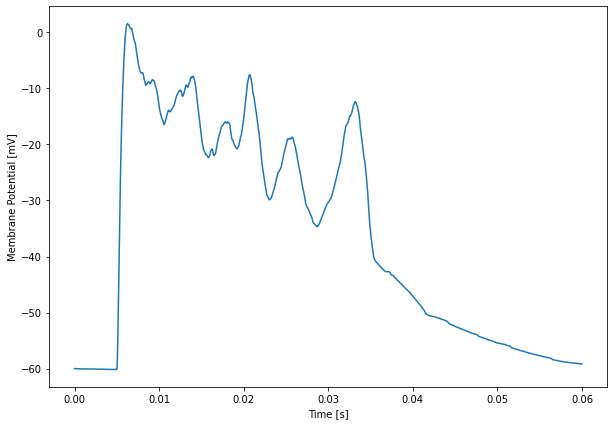

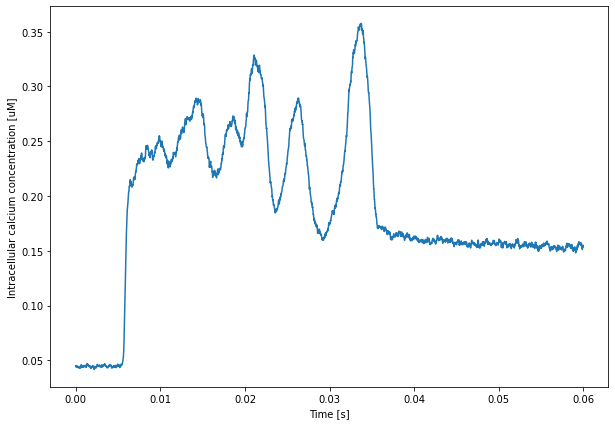

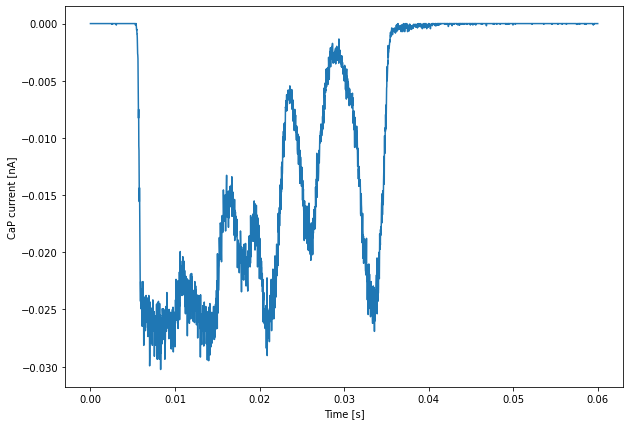

In [1]:
import steps.interface

from steps.saving import *

from matplotlib import pyplot as plt
import numpy as np

with HDF5Handler('scripts/DistCaburst') as hdf:
    Pots, CaConc, Currents = hdf['CaBurstSim'].results
    
    plt.figure(figsize=(10,7))
    plt.plot(Pots.time[-1], 1e3 * np.mean(Pots.data[-1], axis=1))
    plt.xlabel('Time [s]')
    plt.ylabel('Membrane Potential [mV]')
    plt.show()
    
    plt.figure(figsize=(10,7))
    vols = CaConc.metaData['Vols']
    mols = CaConc.data[-1] * vols
    plt.plot(Pots.time[-1], 1e6 * np.sum(mols, axis=1) / sum(vols))
    plt.xlabel('Time [s]')
    plt.ylabel('Intracellular calcium concentration [uM]')
    plt.show()
    
    plt.figure(figsize=(10,7))
    plt.plot(Pots.time[-1], 1e9 * np.sum(Currents.data[-1], axis=1))
    plt.xlabel('Time [s]')
    plt.ylabel('CaP current [nA]')
    plt.show()

The data for these plots has been obtained using the restricted 4 rank run that we discussed previously.